In [148]:
import glob
from collections import OrderedDict

import mne
import pandas as pd
import seaborn as sns
from mne.decoding import Vectorizer
from mne.io.edf.edf import RawEDF
from pyriemann.classification import MDM
from pyriemann.estimation import ERPCovariances, Xdawn
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from p300.stimulus import StimulusHelper

%matplotlib inline

In [149]:
files = glob.glob('../data/*/train_*.fif')

In [150]:
from p300.config import EPOCHS_TMIN, EPOCHS_TMAX

epoch_list = []
for file in files:
    raw = mne.io.read_raw_fif(file, preload=True)  # type: RawEDF
    raw.filter(1, 30, method='iir')

    events = mne.find_events(raw)
    event_id = StimulusHelper.get_train_event_id()
    epoch = mne.Epochs(raw, events, event_id, tmin=EPOCHS_TMIN, tmax=EPOCHS_TMAX, baseline=None, preload=True)
    epoch_list.append(epoch)

epochs = mne.concatenate_epochs(epoch_list)  # type: mne.Epochs
easycap_montage = mne.channels.make_standard_montage('easycap-M1')
epochs.set_montage(easycap_montage)
epochs.pick_types(eeg=True)

Opening raw data file ../data/subject1/train_2022-11-27 13:24:26.564567_raw.fif...
Isotrak not found
    Range : 0 ... 12428 =      0.000 ...    48.547 secs
Ready.
Reading 0 ... 12428  =      0.000 ...    48.547 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

299 events found
Event IDs: [1 2]
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 299 events and 132 original time points ...
3 bad epochs dropped
Opening raw data file ../data/subject1/train_2022-11-27 13:22:52.920185_raw.fif...
Isotrak not found
    Range : 0 ... 12437 =      0.000 ...    48.582 secs
Ready.
Reading 0 ... 12437  =      0.000 ...    48.582 secs...
Filteri

Number of events,1776
Events,NonTarget: 1482Target: 294
Time range,-0.012 – 0.500 sec
Baseline,off


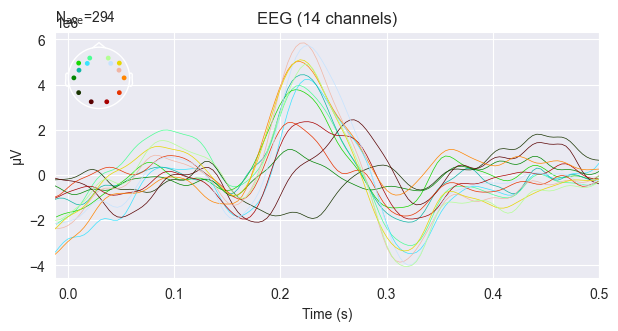

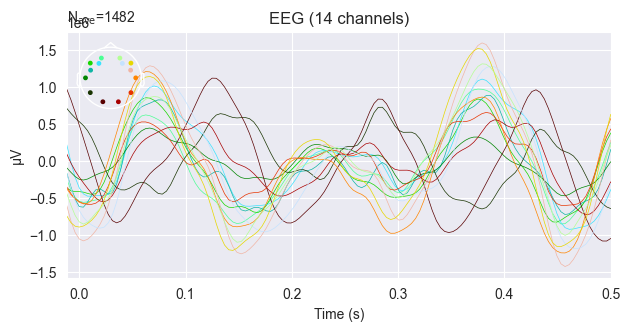

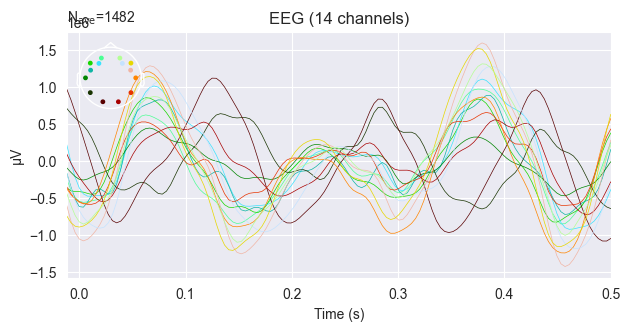

In [151]:
epochs['Target'].average().plot()
epochs['NonTarget'].average().plot()
#

Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


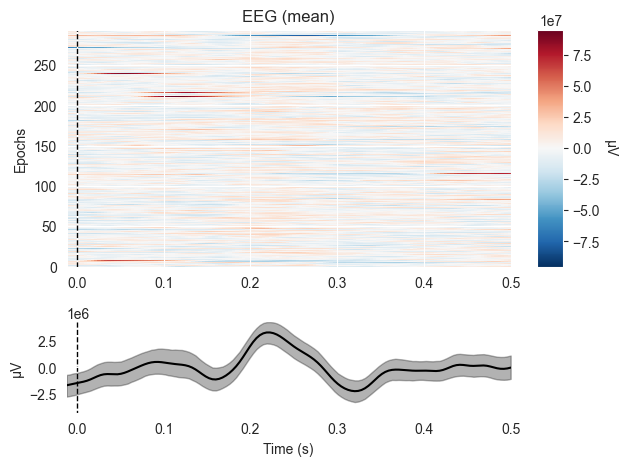

Not setting metadata
1482 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


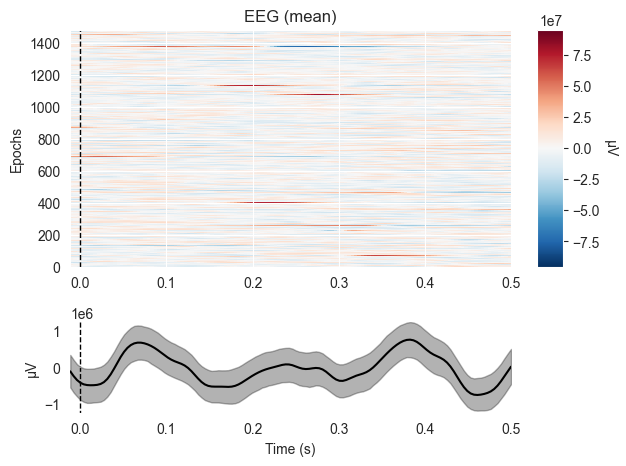

[<Figure size 640x480 with 3 Axes>]

In [152]:
from matplotlib import pyplot as plt

mne.viz.plot_epochs_image(epochs["Target"], show=True, combine='mean')
mne.viz.plot_epochs_image(epochs["NonTarget"], show=True, combine='mean')

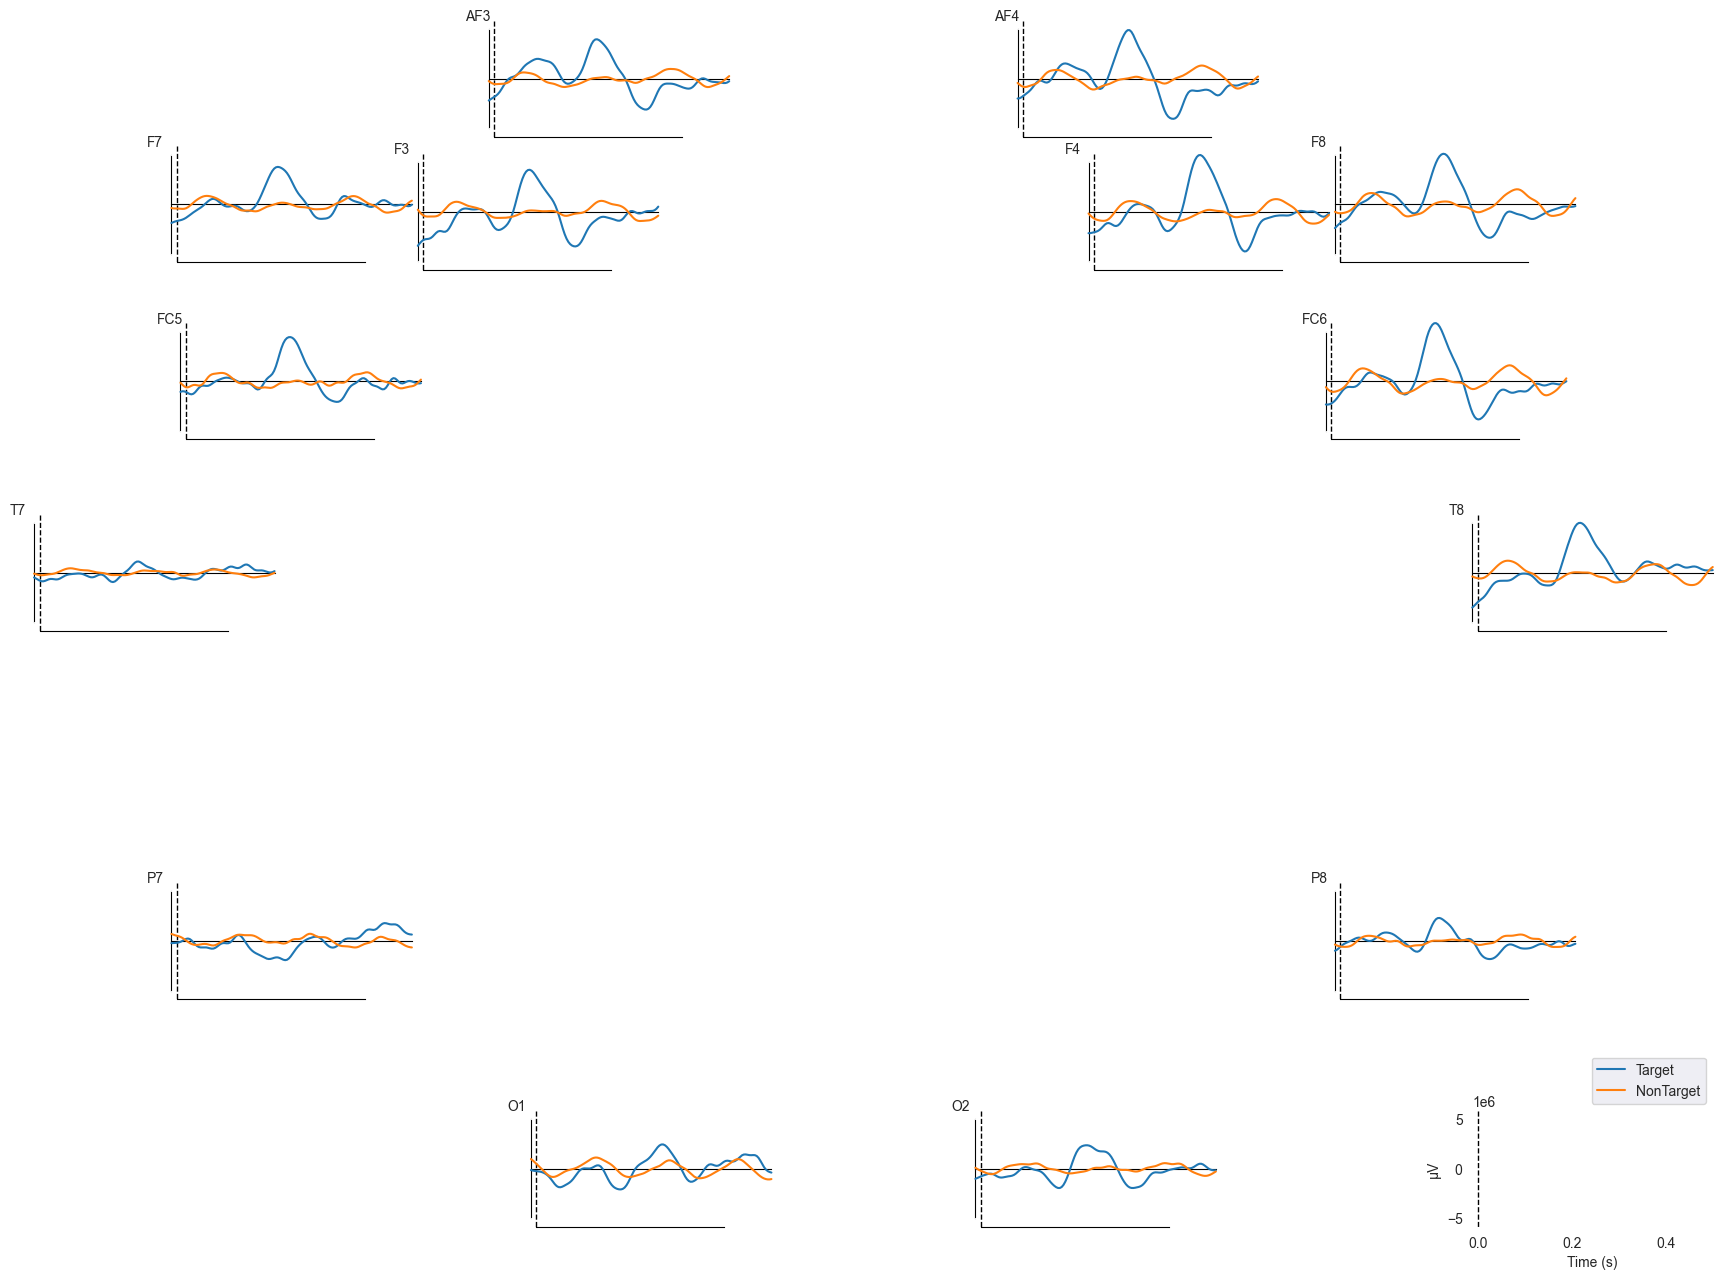

[<Figure size 1800x1400 with 15 Axes>]

In [153]:
e1 = epochs['Target'].average()
e2 = epochs['NonTarget'].average()

mne.viz.plot_compare_evokeds([e1, e2], axes='topo')

combining channels using "gfp"
combining channels using "gfp"


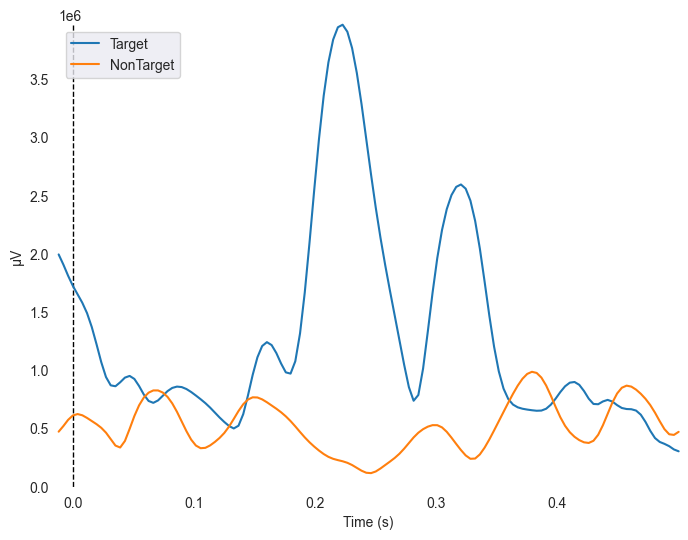

[<Figure size 800x600 with 1 Axes>]

In [154]:
e1 = epochs['Target'].average()
e2 = epochs['NonTarget'].average()

mne.viz.plot_compare_evokeds([e1, e2])

In [155]:
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(max_iter=10000))
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())


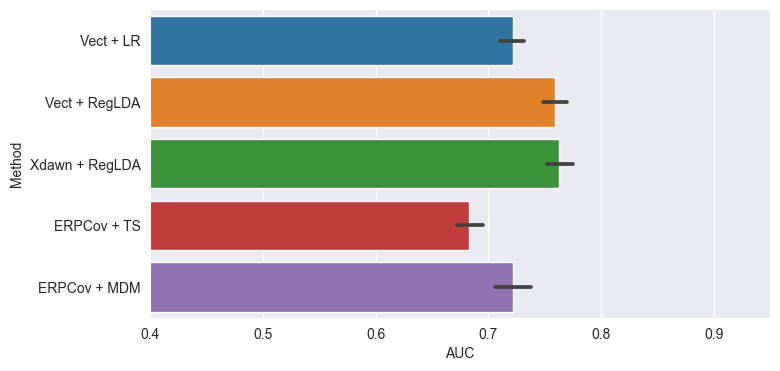

In [156]:
X = epochs.get_data()
y = epochs.events[:, -1]

# define cross validation
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m] * len(res))

results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8, 4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 0.95)
sns.despine()